### Exercice 6. Boussinesq Problem

The goal of this exercise is to use our developed poro-elasticity code to solve the problem of the loading of a foundation, respectively the Boussinesq problem of an axisymmetric load.

In [1]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt
import pygmsh

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

# scipy is an extension for numpy, used extensively in scientific computing
import scipy as sp

# The following lines are though to import the source functions
import sys
sys.path.append('../src')

# And we import the necessary tools from our source folder.
from MesherWrapper import Mesh
from MeshUtils import MeshUtils
import MatrixAssembly
import PoroElasticProperties as prop

### The Boussinesq problem. Solution of axissymmetric elasticity

Boussinesq has derived an analytical solution for the stress in a homogeneous medium after axisymmetric loading, interpretable as the loading from a circular foundation of radius $R_f$. We will focus on numerically solving the undrained response.

### 1. Defining the mesh


We will begin by defining the mesh. We first create a mesh refinement at the point of the singularity, the plate's tip. To do so, we will define a custom function for the element size, making use of $\tanh(x)$.

Text(0, 0.5, 'Mesh size')

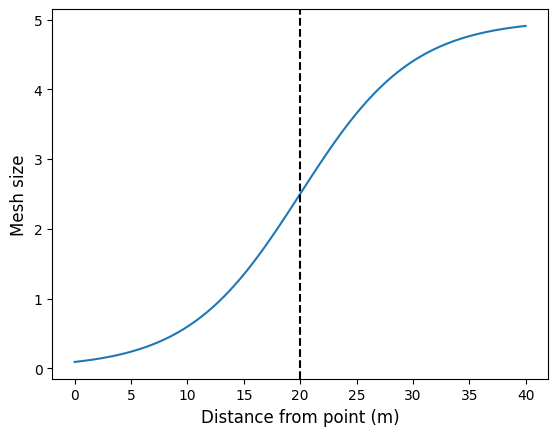

In [2]:
# Defining a hyperbolic tangent function for the mesh-size near the plate
def tanh(dist, max_dist, sharpness, l0, l1, eps=1e-10):
    return  (l1 - l0) * 0.5 * (np.tanh((dist - max_dist)/sharpness) + eps + 1) + l0
    
# Defining the parameters of the mesh
max_dist = 20       # gives the central point of the hyperbolic tangent
sharpness = 10      # gives the inflection points of the hyperbolic tangent
min_lc = 0.001      # defines the fines mesh-size (closest to the plate)
max_lc = 5.0        # defines the coarsest mesh-size (farthest away)

# Visualize the evolution of the mesh size up to the maximum distance.
d = np.linspace(0, 2 * max_dist, 100)
plt.plot(d, tanh(d, max_dist, sharpness, min_lc, max_lc))
plt.axvline(max_dist, c='k', ls='dashed')
plt.xlabel('Distance from point (m)')
plt.ylabel('Mesh size')

The previously defined function is now used to refine the mesh in a axisymmetric manner around the plate.

The total number of nodes in the constant mesh is 2092
The total number of nodes in the linear mesh is 8223


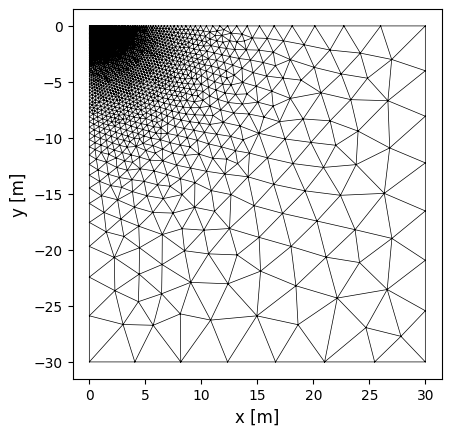

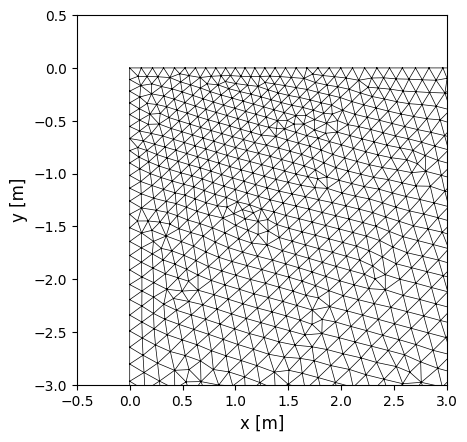

In [3]:

# We define the mesh
R_f = 1                 # The radius of the plate
R = 30                  # The radius of the total domain solved
depth = R_f * R         # The depth (along z) of the domain solved

# As always, we define a geometry for the mesh
with pygmsh.geo.Geometry() as geom:
    # We define a box of the domain within which we solve the problem
    # Complete below
    # box = geom.add_polygon()
    box = geom.add_polygon([[0, 0],
                            [0, -depth],
                            [R, -depth],
                            [R, 0],
                            [R_f, 0]])

    # We set a callback on the mesh size, this function allows us to refine the fracture
    geom.set_mesh_size_callback(lambda dim, tag, x, y, z, lc : tanh(np.sqrt((x - R_f)**2 + y**2), max_dist, sharpness, min_lc, max_lc),
                                ignore_other_mesh_sizes=False)

    # And we generate the mesh
    out = geom.generate_mesh()

# We can now generate our mesh. Remember that the problem is axisymmetric
mesh3 = Mesh(out, simultype='axis')

# We can use the mesh.plot() function to easily show it
mesh3.plot()
plt.xlabel('x [m]')
plt.ylabel('y [m]')

# We also show a zoom on the upper left corner (at the plate)
mesh3.plot()
plt.xlim(-0.5, 3)
plt.ylim(-3, 0.5)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

# And we now switch to also have a quadratic mesh
mesh6 = MeshUtils.tri3_to_tri6(mesh3)
print(f'The total number of nodes in the constant mesh is {mesh3.number_nodes}')
print(f'The total number of nodes in the linear mesh is {mesh6.number_nodes}')


### 2. Boundary conditions

We need to set the boundary conditions which are a mix of surface tractions (where we have the plate) and displacement conditions.

#### Displacement conditions
The displacement boundary conditions are such that we restrict movement on the lower and the right boundary (far-field), as well as the horizontal displacement on the axis of symmetry (left boundary), where the latest is verified automatically (derive on your own why this is the case).


Text(0, 0.5, 'y [m]')

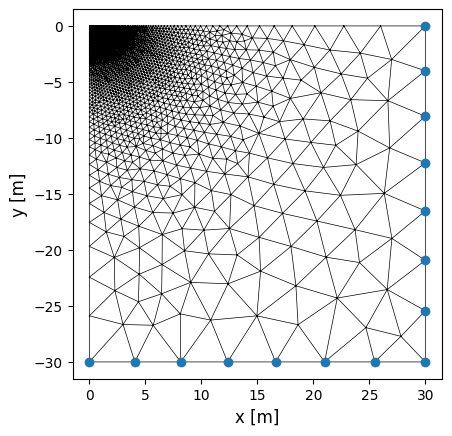

In [4]:
# Note that in the following we can perform all the steps
# either for the linear mesh (mesh3) or the quadratic mesh
# (mesh6) without having to change anything on the code.

# We choose the mesh to use
# Complete below:
mesh = mesh3

# We define the boundaries of the box
# Complete below:

bottom = np.argwhere((mesh.nodes[:, 1] == -depth))[:, 0]  # The bottom of the box
right = np.argwhere((mesh.nodes[:, 0] == R))[:, 0]        # The right boundary
left = np.argwhere((mesh.nodes[:, 0] == 0))[:, 0]         # The axis of symmetry
top = np.argwhere((mesh.nodes[:, 1] == 0))[:, 0]          # The top of the box

# We get the fixed nodes and the corresponding degrees of freedom (DOF)
# Complete below:

fixed_nodes = np.unique(np.hstack((bottom, right)))
fixed_dof = np.hstack((2 * fixed_nodes, fixed_nodes * 2 + 1))

# We visualize our choices of boundaries
fig, ax = mesh.plot()
ax.scatter(*mesh.nodes[fixed_nodes].T, zorder=10)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

#### Surface tractions
The surface traction, cannot simply be distributed onto the nodes but needs to be lumped correctly. This is done through a line integral on the edge where the force is applied, which naturally depends on the order of the elements's shape function.

/Users/antareep/Desktop/PYTHON-TEST/Civil-423-students-2024/exercise_week6/../src/Elements.py:332: RuntimeWarning: divide by zero encountered in divide
  DNaDX = DN / j


relative difference is -0.00 %


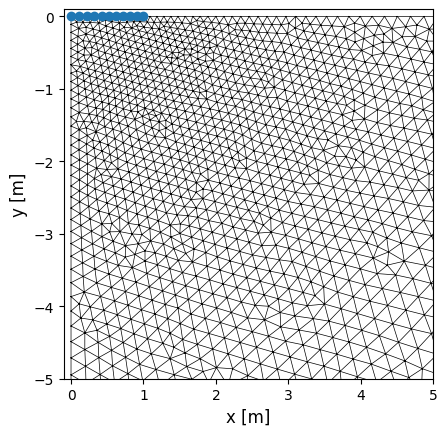

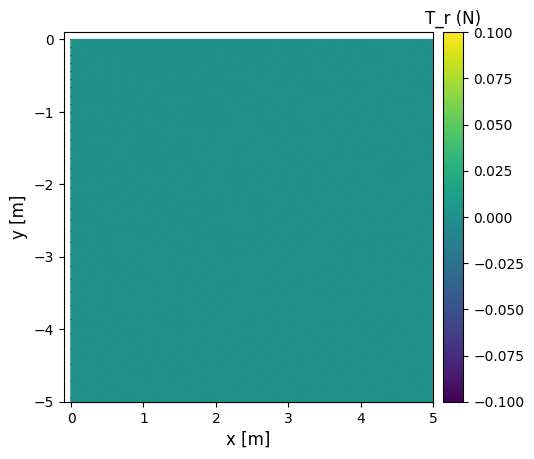

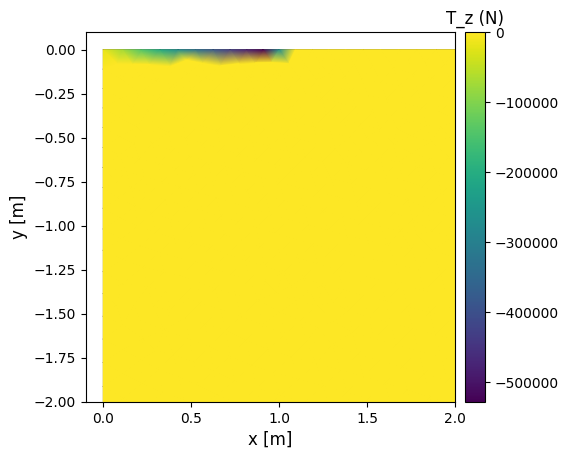

In [5]:
# We define the boundary on which we will have tractions
# Complete below:
# traction_boundary = 
traction_boundary = np.argwhere((mesh.nodes[:, 0] <= R_f) & (mesh.nodes[:, 1] == 0))

# We visualize the traction boundary
mesh.plot()
plt.scatter(*mesh.nodes[traction_boundary].T)
plt.xlim(-0.1, 5)
plt.ylim(-5, 0.1)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

# And we calculate the nodal forces arising from the surface load
# Complete below

area = R_f ** 2 * np.pi     # The area of the round plate
ts = [0, -1e6]                # The traction vector with its x, and y coordinate.
# Note that the traction vector is always defined in the "base" coordinate system.
# The "base" coordinate system of the code is x positive towards the right and y
# positive upwards

# We can now use the function assemble_tractions_over_line() to get the nodal
# force vector. Familiarize yourself with its API and use it correctly.
# Complete below
fs = MatrixAssembly.assemble_tractions_over_line(mesh, traction_boundary, ts)

# For ease of plotting, we arrange the nodel forces as a traction
# vector with two colons for x and y components.
# Complete below
# sigma =
sigma = fs.reshape(2, -1, order='F')

# And visualize the x-component
fig, ax, cb = mesh.plot(sigma[0])
ax.set_xlim(-0.1, 5)
ax.set_ylim(-5, 0.1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
cb.ax.set_title('T_r (N)')

# And visualize the y-component
fig, ax, cb = mesh.plot(sigma[1])
ax.set_xlim(-0.1, 2)
ax.set_ylim(-2, 0.1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
cb.ax.set_title('T_z (N)')

# the relative difference between the analytiacl applied traction and the numerical should be close to zero
difference = 100 * (fs.sum() - ts[1] * area)/(ts[1] * area)
print(f'relative difference is {difference:.2f} %')


### 3. System assmbly and solution of the system

We now want to assemble the matrices and solve the system. For now we are only solving the elastic system. You are asked to assemble the matrices and solve the problem.

In [6]:
# We define first the elastic parameters of the problem
# Complete below
# E =
# nu =
E = 20 * 1e6
nu = 0.3

# We can now asseble the stiffnes matrix. The system is equivalent to the assembly
# of the conducitvity and mass matrix. Only the components change
# Note that you'll have to implement some parts of the following function
K = MatrixAssembly.assemble_stiffness_matrix(mesh, E, nu)

# Solution of the system
# We define first the known displacements
u_set = fixed_dof * 0

# We can no assemble the system of equations to solve (RHS and LHS)
# Complete below

eq_to_solve = np.setdiff1d(np.arange(mesh.number_nodes * 2), fixed_dof)
f = (-K[eq_to_solve][:, fixed_dof]).dot(u_set) + fs[eq_to_solve]

# After solving the system, we can get back the displacements everywhere and 
# glue the solution back together
# Complete below
                                                          # Combining the two
u_aux = sp.sparse.linalg.spsolve(K[eq_to_solve][:, eq_to_solve], f)     # Solution of unkown components
u_res = np.zeros(mesh.number_nodes * 2)                                 # Complete solution initiation
u_res[eq_to_solve] = u_aux                                              # Combining the two

The next section is solely to visualize the results

Text(0.5, 1.0, 'u_z [m]')

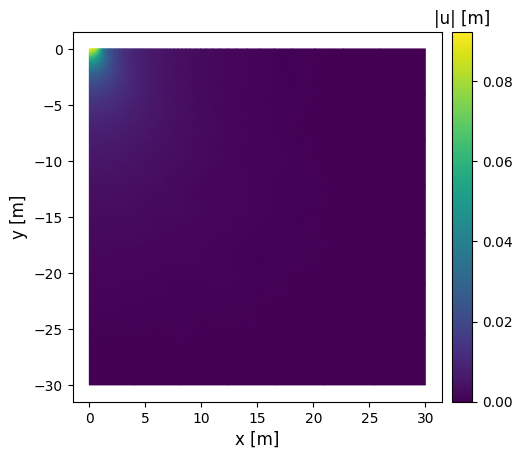

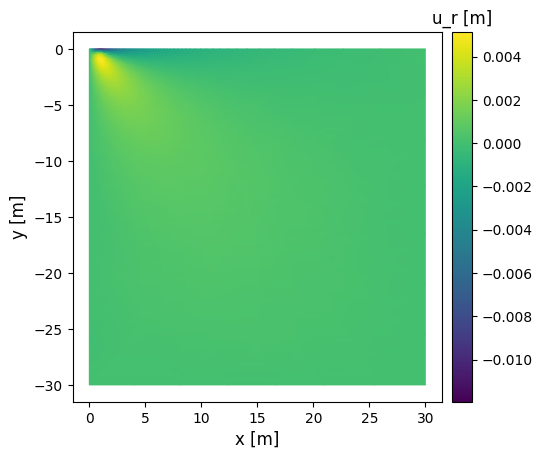

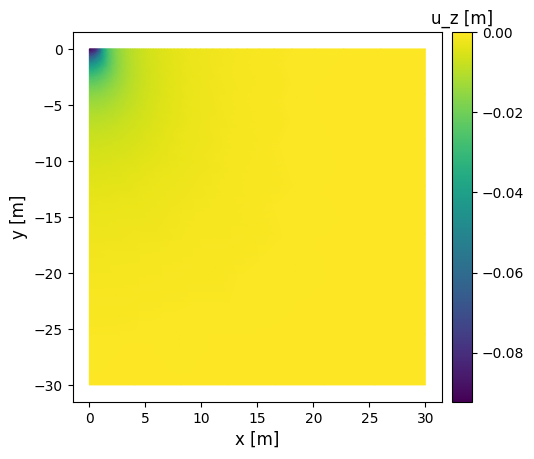

In [7]:
# To easier visualize the solution to the problem we create a reshaped vector of
# displacements.
# Complete below
# udisp =
udisp = u_res.reshape(2, -1, order='F')

# Finally, we can visualize our results and show the magnitude of deformation
fig, ax, cb = mesh.plot(np.linalg.norm(udisp, axis=0), c='none',)
#ax.set_xlim(-0.5, 1)
#ax.set_ylim(-1, 0.5)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
cb.ax.set_title('|u| [m]')

# We further show the displacements in r
fig, ax, cb = mesh.plot(u_res[0:-1:2], c='none',)
#ax.set_xlim(-0.5, 1)
#ax.set_ylim(-1, 0.5)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
cb.ax.set_title('u_r [m]')

# We further show the settlements in z
fig, ax, cb = mesh.plot(u_res[1::2], c='none',)
#ax.set_xlim(-0.5, 1)
#ax.set_ylim(-1, 0.5)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
cb.ax.set_title('u_z [m]')

#### 3.1 Comparison to analytical solution for point force

We now want to compare our results to the solution of a point force. We notably compare the radial and vertical displacements along $r$ for $z=0$. The analytical solutions derived by Boussinesq are given as:

$u_{r}=P\frac{1+\nu}{2\pi E}\frac{1}{R}\left(r^{2}\vert z\vert R^{3}-(1-2\nu)*(1-\frac{\vert z\vert}{R})\right)$

$u_{z}=P\frac{1+\nu}{2\pi E}\frac{1}{R}\left(2(1-\nu)+\frac{z^{2}}{R^{2}}\right)$

In [8]:
# We first define the functions giving the analytical solution for a point load
def point_load_solution_boussinesq(P, E, nu, coord):
    # We get the distance to the Load
    R = np.linalg.norm(coord, axis=1)

    # We get the radial displacement
    u_r = P * (1 + nu) / (2 * np.pi * E) * 1 / R * (coord[:, 0] ** 2 * abs(coord[:, 1]) * R ** 3 - (1 - 2 * nu) * (1 - abs(coord[:, 1]) / R))
    # We get the vertical displacement
    u_z = - P * (1 + nu) / (2 * np.pi * E) * 1 / R * (2 * (1 - nu) + coord[:, 1] ** 2 / R ** 2)
    # Note that the minus stems from the definition of the coordinate system.

    # we return them as a matrix with two columns
    return np.vstack((u_r, u_z)).T

It is now possible to compare this analytical solution with our numerical one. Here you can notably investigate the effect of mesh refinement.

/var/folders/8d/mwtqqbq11njdh0f38ycns9980000gn/T/ipykernel_55943/3346721651.py:7: RuntimeWarning: divide by zero encountered in divide
  u_r = P * (1 + nu) / (2 * np.pi * E) * 1 / R * (coord[:, 0] ** 2 * abs(coord[:, 1]) * R ** 3 - (1 - 2 * nu) * (1 - abs(coord[:, 1]) / R))
/var/folders/8d/mwtqqbq11njdh0f38ycns9980000gn/T/ipykernel_55943/3346721651.py:7: RuntimeWarning: invalid value encountered in divide
  u_r = P * (1 + nu) / (2 * np.pi * E) * 1 / R * (coord[:, 0] ** 2 * abs(coord[:, 1]) * R ** 3 - (1 - 2 * nu) * (1 - abs(coord[:, 1]) / R))
/var/folders/8d/mwtqqbq11njdh0f38ycns9980000gn/T/ipykernel_55943/3346721651.py:9: RuntimeWarning: divide by zero encountered in divide
  u_z = - P * (1 + nu) / (2 * np.pi * E) * 1 / R * (2 * (1 - nu) + coord[:, 1] ** 2 / R ** 2)
/var/folders/8d/mwtqqbq11njdh0f38ycns9980000gn/T/ipykernel_55943/3346721651.py:9: RuntimeWarning: invalid value encountered in divide
  u_z = - P * (1 + nu) / (2 * np.pi * E) * 1 / R * (2 * (1 - nu) + coord[:, 1] ** 2 / R 

Text(0, 0.5, 'Scaled absolute error on settlement')

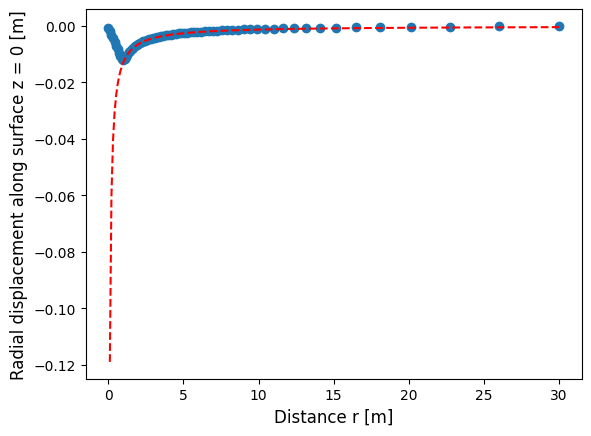

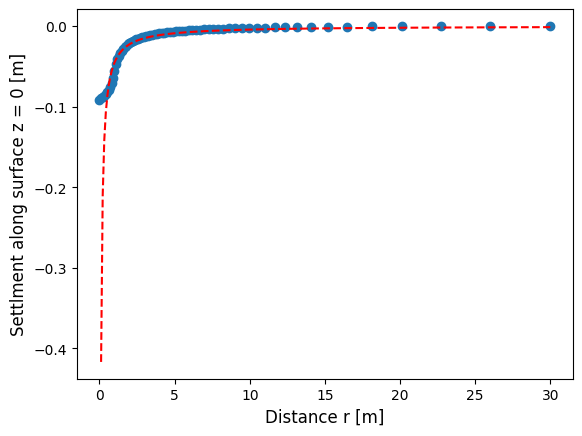

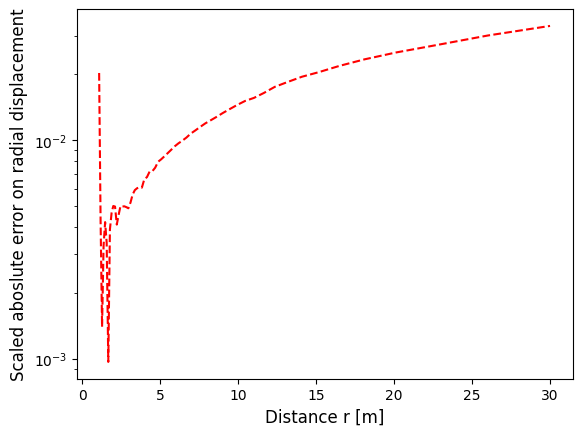

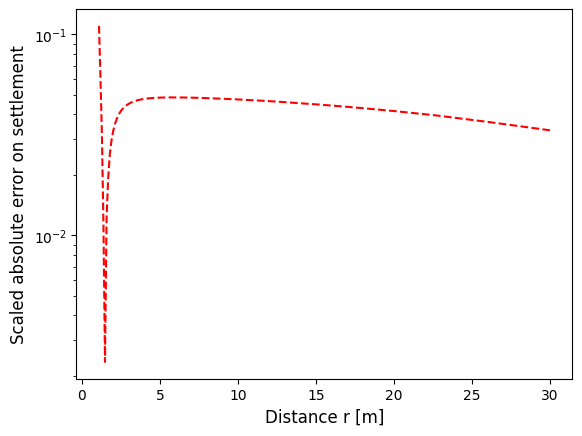

In [9]:
# lets first order the elements on top for plotting regions
indices = np.argsort(mesh.nodes[top, 0])
top = top[indices]

# We extract the displacements along the top surface and the coordinates of the corresponding nodes
# Complete below

u_top = udisp[:, top].T
coords_top = mesh.nodes[top]

# Now we calculate the the analytical solution there
# Complete below

P = np.pi * R_f ** 2 * abs(ts[1])
u_top_analytical = point_load_solution_boussinesq(P, E, nu, coords_top)

# We plot the lines to compare the analytical and theoretical solution on the top surface.
plt.figure(1)
plt.plot(coords_top[:, 0], u_top_analytical[:, 0], 'r--')
plt.scatter(coords_top[:, 0], u_top[:, 0])
plt.xlabel('Distance r [m]')
plt.ylabel('Radial displacement along surface z = 0 [m]')

# We plot the lines to compare the analytical and theoretical solution on the top surface.
plt.figure(2)
plt.plot(coords_top[:, 0], u_top_analytical[:, 1], 'r--')
plt.scatter(coords_top[:, 0], u_top[:, 1])
plt.xlabel('Distance r [m]')
plt.ylabel('Settlment along surface z = 0 [m]')

# It is of course more interesting to see the error. We compare notably the error once we are outside of
# the foundation (e.g., r >=1), note that we scale the error with its value at the edge of the foundation.
top_out_of_found = np.argwhere(mesh.nodes[top, 0] > R_f)[:, 0]
abs_scaled_error = abs((u_top_analytical - u_top) / point_load_solution_boussinesq(P, E, nu, np.asarray([[R_f, 0]])))

# We plot the error to compare the analytical and theoretical solution on the top surface.
plt.figure(3)
plt.plot(coords_top[top_out_of_found, 0], abs_scaled_error[top_out_of_found, 0], 'r--')
plt.yscale('log')
plt.xlabel('Distance r [m]')
plt.ylabel('Scaled aboslute error on radial displacement')

# We plot the error to compare the analytical and theoretical solution on the top surface.
plt.figure(4)
plt.plot(coords_top[top_out_of_found, 0], abs_scaled_error[top_out_of_found, 1], 'r--')
plt.yscale('log')
plt.xlabel('Distance r [m]')
plt.ylabel('Scaled absolute error on settlement')


#### 3.2 Comparison to the solution for a circular footing

The previous comparison has been done to a point force which is not what we have here. In a second step, we now compare our solutions to the ones of a circular footing, which represents the configuration we actually have here.

$u_{z}(r=0,z=0)=q\times R_{f}\frac{2(1-\nu^{2})}{E}$

$u_{z}(r=R_{f},z=0)=q\times R_{f}\frac{4(1-\nu^{2})}{\pi E}$

In [10]:
# We first calculate the analytical values
# Complete below
# uz_analytical_r0z0 =                                                  # settlement at r = 0 and z = 0
# uz_analytical_rRfz0 =                                                 # settlement at r = R_f and z = 0
uz_analytical_r0z0 = ts[-1] * R_f * 2 * (1 - nu ** 2) / E               # settlement at r = 0 and z = 0
uz_analytical_rRfz0 = ts[-1] * R_f * 4 * (1 - nu ** 2) / (np.pi * E)    # settlement at r = R_f and z = 0

# We then get the indices
# Complete below
# ind_r0z0 = 
# ind_rRfz0 =
ind_r0z0 = np.argwhere(mesh.nodes[top, 0] == 0)[:, 0]
ind_rRfz0 = np.argwhere(mesh.nodes[top, 0] == R_f)[:, 0]

# Printing settlements and error
print(f'The numerical settlement at the center of the foundation is: {u_top[ind_r0z0, 1][0]} [m]')
print(f'The theoretical settlement at the center of the foundation is: {uz_analytical_r0z0} [m]')
print(f'The absolute scaled error between the analytical and theoretical settlement at the center of the foundation is: {abs((uz_analytical_r0z0-u_top[ind_r0z0, 1][0])/uz_analytical_r0z0)*100} %')

# Printing settlements and error
print(f'The numerical settlement at the edge of the foundation is: {u_top[ind_rRfz0, 1][0]} [m]')
print(f'The theoretical settlement at the edge of the foundation is: {uz_analytical_rRfz0} [m]')
print(f'The absolute relative scaled between the analytical and theoretical settlement at the edge of the foundation is: {abs((uz_analytical_rRfz0-u_top[ind_rRfz0, 1][0])/uz_analytical_r0z0)*100} %')

The numerical settlement at the center of the foundation is: -0.09222090085600138 [m]
The theoretical settlement at the center of the foundation is: -0.091 [m]
The absolute scaled error between the analytical and theoretical settlement at the center of the foundation is: 1.3416492923092065 %
The numerical settlement at the edge of the foundation is: -0.05538687658607828 [m]
The theoretical settlement at the edge of the foundation is: -0.0579323992854499 [m]
The absolute relative scaled between the analytical and theoretical settlement at the edge of the foundation is: 2.79727769161717 %


### 4. Stress Calculations

We want to compute the stress only from the given solution of displacements $u$. As gradients of displacements are computed at the integration points, the stresses are also defined there. This makes the plotting task complicated, as stresses become discontinuous at the elemental boundaries. In order to improve that, we want to have stresses defined at the nodes, which would make stress-fields continuous and easily plottable. Defining streses at the nodes requires projection operation. We will use a `project_stress` function that computes the fluxes at the integration points and then projects them at the nodes.

To make the following cell work, you have to code up the function `project_stress` in MatrixAssembly.py.

In [11]:
# We calculate the different comoponents of the stresses
sigma_rr, sigma_zz, tau_rz, sigma_tt = MatrixAssembly.project_stress(mesh, E, nu, u_res)

As a verification we will compare this results to the analytical solution along z for $r=0$ (Boussinesq, 1878).

$\sigma_{zz}\left(z\right)=q\left(1-\left(\frac{1}{1+\left(\frac{R_{f}}{z}\right)^{2}}\right)^{3/2}\right)$

In [14]:
# We first define the function giving the analytical solution
# Complete below
# def point_load_solution_boussinesq_stresses(q, R_f, z):
def point_load_solution_boussinesq_stresses(q, R_f, z):
    # We get the stresses
    sigma_zz = q * (1 - (1 / (1 + (R_f / z) ** 2)) ** (3 / 2))
    # we return them as a matrix with two columns
    return sigma_zz

Finally, we compare this results to the our numerical solution

/var/folders/8d/mwtqqbq11njdh0f38ycns9980000gn/T/ipykernel_55621/4058751.py:6: RuntimeWarning: divide by zero encountered in divide
  sigma_zz = q * (1 - (1 / (1 + (R_f / z) ** 2)) ** (3 / 2))


Text(0, 0.5, 'Depth below foundation centre [m]')

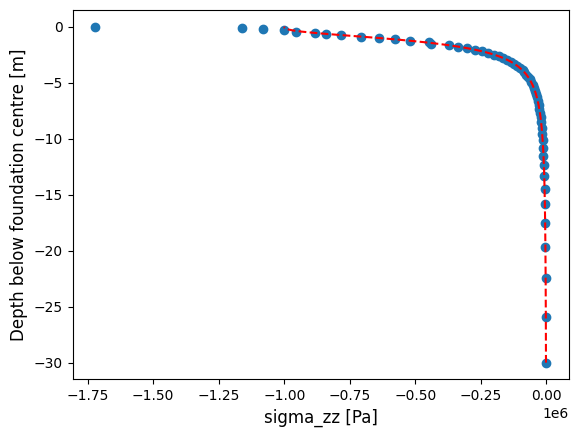

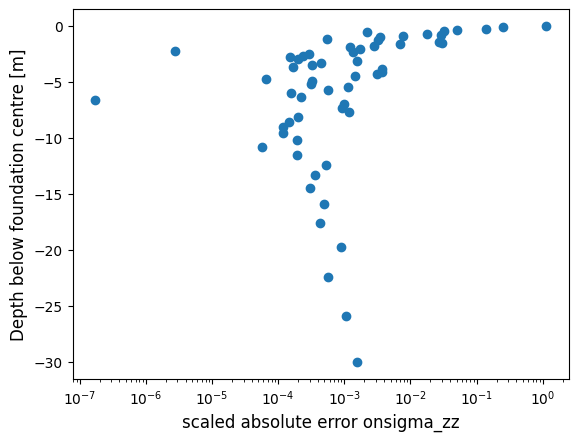

In [15]:
# lets first order the elements on top for plotting regions
indices = np.argsort(mesh.nodes[left, 1])
left = left[indices]

# We get the analytical stresses centrally below the foundation
sigma_zz_analytical = point_load_solution_boussinesq_stresses(ts[-1], R_f, mesh.nodes[left, 1])

# We plot the lines to compare the analytical and theoretical solution on the top surface.
plt.figure(1)
plt.plot(sigma_zz_analytical, mesh.nodes[left, 1], 'r--')
plt.scatter(sigma_zz[left], mesh.nodes[left, 1])
plt.xlabel('sigma_zz [Pa]')
plt.ylabel('Depth below foundation centre [m]')

# It is of course more interesting to see the error.
# we scale by the analytical solution at a depth of z = R_f
scaled_absolute_error = abs((sigma_zz_analytical - sigma_zz[left]) / point_load_solution_boussinesq_stresses(ts[-1], R_f, R_f))

# We plot the lines to compare the analytical and theoretical solution on the top surface.
plt.figure(2)
plt.scatter(scaled_absolute_error, mesh.nodes[left, 1])
plt.xscale('log')
plt.xlabel('scaled absolute error onsigma_zz')
plt.ylabel('Depth below foundation centre [m]')